In [51]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob

In [75]:
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [71]:
class Opts():
    def __init__(self):
        self.train_data_path = "./working/train/"
        self.test_data_path = "./working/test/"
        self.csv_path = "./meta"
        self.data_path = "./data/"
        self.model_save_path = "./output/"
        self.plot_save_path = "./plot/RF"
        self.model_name = "RF.h5"
        
        if not os.path.exists(self.train_data_path):
            os.makedirs(self.train_data_path)
        if not os.path.exists(self.test_data_path):
            os.makedirs(self.test_data_path)
        if not os.path.exists(self.csv_path):
            os.makedirs(self.csv_path)
        if not os.path.exists(self.plot_save_path):
            os.makedirs(self.plot_save_path)

In [72]:
opts = Opts()

In [55]:
def df_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

train_csv_path = os.path.join(opts.csv_path, "train.csv")
test_csv_path = os.path.join(opts.csv_path, "test.csv")

train_file_df, test_file_df = df_from_csv(train_csv_path), df_from_csv(test_csv_path)

In [56]:
# use mfcc as feature
def generateFeature(df, opts):
    X, y = [], []
    for idx, (file_path, label) in enumerate(zip(df['file_paths'], df['labels'])):
        s, sr = librosa.load(file_path)
        mfccs = np.mean(librosa.feature.mfcc(y=s, sr=sr, n_mfcc=200).T, axis=0)
        X.append(mfccs)
        y.append(label)
    return X, y

In [57]:
X_train, y_train = generateFeature(train_file_df, opts)
X_test, y_test = generateFeature(test_file_df, opts)

In [58]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
y_predict = model.predict(X_test)

In [78]:
model.score(X_test, y_test)

0.29945945945945945

In [79]:
labels = ['AC', 'CH', 'CP', 'DB', 'DR', 'EI', 'GS', 'JH', 'SI', 'SM']
cm = confusion_matrix([labels[i] for i in y_test], \
                      [labels[j] for j in y_predict], \
                      labels)

In [69]:
def plot_confusion_matrix(cm,
                          target_names,
                          opts,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
        -----
        plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                                  # sklearn.metrics.confusion_matrix
                              normalize    = True,                # show proportions
                              target_names = y_labels_vals,       # list of names of the classes
                              title        = best_estimator_name) # title of graph

        Citiation
        ---------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(opts.plot_save_path, title), bbox_inches='tight')
    plt.show()

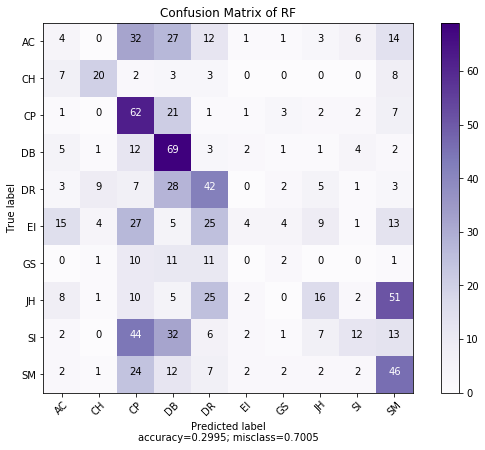

In [80]:
plot_confusion_matrix(cm, 
                      labels,
                      opts,
                      normalize = False,
                      title = "Confusion Matrix of RF")

In [61]:
import coremltools
mlmodel = coremltools.converters.sklearn.convert(model)
mlmodel.author = "Candy Dong"
mlmodel.input_description["input"] = "an audio clip"
mlmodel.output_description["classLabel"] = "a integer value"
mlmodel.short_description = "urban sound classifier"
mlmodel.save(os.path.join(opts.model_save_path,"RF.mlmodel"))